In [2]:
using Revise

In [3]:
using Distributed
procs_to_use = 1
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [4]:
@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    StructArrays,
    StaticArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples,
    StatsBase,
    Plots, 
    Distributions
;

Precompiling OpticalBlochEquations
  ✓ OpticalBlochEquations
  1 dependency successfully precompiled in 24 seconds. 340 already precompiled.


In [5]:
@everywhere include("helper_functions.jl")
;

# Define molecular states for the laser cooling transition

In [6]:
# Define constants for the laser cooling transition
@everywhere begin
    @consts begin
        λ = 626e-9             # wavelength of transition
        Γ = 2π * 6.4e6         # transition linewidth
        m = @with_unit 57 "u"  # mass of CaOH
        k = 2π / λ             # wavenumber of transition
    end
end
;

In [7]:
@everywhere include("CaOH_X(000).jl")
@everywhere include("CaOH_A(000).jl")
;

In [8]:
@everywhere begin
    H = CombinedHamiltonian([X_state_ham, A_state_ham])
    evaluate!(H)
    QuantumStates.solve!(H)
    update_basis_tdms!(H)
    update_tdms!(H)
    
    ground_state_idxs = 1:12
    excited_state_idxs = 17:20
    states_idxs = [ground_state_idxs; excited_state_idxs]
    
    ground_states = H.states[ground_state_idxs]
    excited_states = H.states[excited_state_idxs]
    
    d = H.tdms[states_idxs, states_idxs, :]
    states = H.states[states_idxs]
end

In [9]:
@everywhere begin
    Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
    Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
    Zeeman_z(state, state′) = Zeeman(state, state′, 0)
    
    Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
    Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
    Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
end
;

# Define experimental parameters

In [10]:
@everywhere begin

    # Define B field gradient and ramp time
    B_grad_start = 0.
    B_grad_end = 78.
    B_ramp_time = 4e-3 / (1/Γ)
    s_ramp_time = 4e-3 / (1/Γ)
    
    T_initial = 35e-6
    
end

## Simulate trajectory for single particle

In [11]:
@everywhere begin
    ### SIMULATION PARAMETERS ###
    sim_type = Float64
    
    # DEFINE STATES #
    energy_offset = energy(states[13])
    energies = energy.(states)
    # energies[13:16] .-= energy_offset
    
    # DEFINE FREQUENCIES #
    detuning = +7.6
    δ1 = +0.0
    δ2 = -1.00
    δ3 = +0.75
    
    Δ1 = 1e6 * (detuning + δ1)
    Δ2 = 1e6 * (detuning + δ2)
    Δ3 = 1e6 * (detuning + δ3)
    
    ω1 = 2π * (energy(states[end]) - energy(states[1]) + Δ1)
    ω2 = 2π * (energy(states[end]) - energy(states[10]) + Δ2)
    ω3 = 2π * (energy(states[end]) - energy(states[10]) + Δ3)
    
    freqs = [ω1, ω2, ω3]
    # freqs .-= 2π .* energy_offset
    
    # DEFINE SATURATION INTENSITIES #
    Isat = π*h*c*Γ/(3λ^3)
    P = 0.5 * 0.7 * 13.1e-3 # 13.1 mW/1 V, factor of 0.5 to match scattering rates
    I = 2P / (π * 5e-3^2) # 10 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = 0.37I/Isat
    s2 = 0.28I/Isat
    s3 = 0.35I/Isat
    
    sats = [s1, s2, s3]
    
    # DEFINE POLARIZATIONS #
    pols = [σ⁻, σ⁺, σ⁻]
    
    # DEFINE INITIAL WAVEFUNCTION #
    ψ0 = zeros(Complex{sim_type}, length(states))
    ψ0[1] = 1.
end
;

In [12]:
@everywhere function flip(ϵ)
    return SVector{3,ComplexF64}(ϵ[3],-ϵ[2],ϵ[1])
end
;

In [13]:
@everywhere function get_int_type(T)
    if T == Float32
        return Int32
    elseif T == Float64
        return Int64
    end
end
;

In [14]:
@everywhere begin
    _Zeeman_x_mat = Zeeman_x_mat[1:12,1:12]
    _Zeeman_y_mat = Zeeman_y_mat[1:12,1:12]
    _Zeeman_z_mat = Zeeman_z_mat[1:12,1:12]
    
    T_initial = 35e-6
    
    params = MutableNamedTuple(
        Zeeman_Hx = MMatrix{size(_Zeeman_x_mat)...}(sim_type.(_Zeeman_x_mat.re)),
        Zeeman_Hy = MMatrix{size(_Zeeman_y_mat)...}(sim_type.(_Zeeman_y_mat.im)),
        Zeeman_Hz = MMatrix{size(_Zeeman_z_mat)...}(sim_type.(_Zeeman_z_mat.re)),
        
        B_ramp_time = B_ramp_time,
        B_grad_start = B_grad_start,
        B_grad_end = B_grad_end,

        s_ramp_time = s_ramp_time,
    
        photon_budget = rand(Geometric(1/13500)),
        
        x_dist = Normal(0,700e-6),
        y_dist = Normal(0,700e-6),
        z_dist = Normal(0,400e-6),
    
        vx_dist = Normal(0, sqrt(kB*T_initial/2m)),
        vy_dist = Normal(0, sqrt(kB*T_initial/2m)),
        vz_dist = Normal(0, sqrt(kB*T_initial/2m)),

        f_z = StructArray(zeros(Complex{sim_type},16,16))
    )
end
;

In [15]:
@everywhere function find_n_g(d)
    n_g = 0
    for j ∈ axes(d,2)
        set_n_g = true
        for i ∈ axes(d,1)
            for q ∈ 1:3
                if norm(d[i,j,q]) > 0 && (i < j)
                    set_n_g = false
                end
            end
        end
        if set_n_g
            n_g = j
        end
    end
    return n_g
end
;

In [16]:
@everywhere function add_terms_dψ(dψ, ψ, p, r, t)

    Zeeman_Hz = p.params.Zeeman_Hz
    Zeeman_Hx = p.params.Zeeman_Hx
    Zeeman_Hy = p.params.Zeeman_Hy

    # set ramp factor
    scalar = t/p.params.B_ramp_time
    scalar = min(scalar, 1.0)
    
    B_grad = scalar * (p.params.B_grad_end - p.params.B_grad_start) + p.params.B_grad_start
    
    gradient_x = +scalar * B_grad * 1e2 / k / 2
    gradient_y = +scalar * B_grad * 1e2 / k / 2
    gradient_z = -scalar * B_grad * 1e2 / k
    
    Bx = gradient_x * r[1]
    By = gradient_y * r[2]
    Bz = gradient_z * r[3]
    
    @turbo for i ∈ 1:12
        dψ_i_re = zero(eltype(dψ.re))
        dψ_i_im = zero(eltype(dψ.im))
        for j ∈ 1:12
            ψ_i_re = ψ.re[j]
            ψ_i_im = ψ.im[j]
            
            # Zeeman x/y/z - always real/imag/real
            Hx_ij = Bx * Zeeman_Hx[i,j]
            Hy_ij = By * Zeeman_Hy[i,j]
            Hz_ij = Bz * Zeeman_Hz[i,j]
            dψ_i_re += ψ_i_re * Hx_ij - ψ_i_im * Hy_ij + ψ_i_re * Hz_ij
            dψ_i_im += ψ_i_im * Hx_ij + ψ_i_re * Hy_ij + ψ_i_im * Hz_ij
            
        end
        dψ.re[i] += dψ_i_im
        dψ.im[i] -= dψ_i_re
    end
  
    return nothing
end
;

In [17]:
@everywhere function initialize_prob(
        sim_type,
        energies,
        freqs,
        sats,
        pols,
        ψ0,
        d,
        m,
        Γ,
        params,
        add_terms_dψ
    )
    intT = get_int_type(sim_type)

    n_states = length(energies)
    n_g = find_n_g(d)
    n_excited = n_states - n_g
    n_freqs = length(freqs)
    
    denom=sim_type((5e-3*k)^2/2)
    
    ω0s = zeros(sim_type,n_states)
    for i ∈ eachindex(ω0s)
        ω0s[i] = 2π * energies[i] / Γ
    end
    # ω0s = round.(ω0s, digits=7)
    
    eiω0ts = zeros(Complex{sim_type},n_states)
    
    ωs = zeros(sim_type,length(freqs))
    for i ∈ eachindex(ωs)
        ωs[i] = freqs[i] / Γ
    end
    # ωs = round.(ωs, digits=7)

    k_dirs = 6
    
    as = zeros(Complex{sim_type},k_dirs,n_freqs)
    ϕs = zeros(sim_type,3,3+n_freqs)
    rs = zeros(sim_type,2,3)
    kEs = zeros(Complex{sim_type}, k_dirs, 3)
    
    idxs = intT.(reshape(collect(1:(3n_freqs)),3,n_freqs))
    
    # define polarization array
    ϵs = zeros(Complex{sim_type},k_dirs,n_freqs,3)
    for i ∈ eachindex(pols)
        pol = pols[i]
        ϵs[1,i,:] .= rotate_pol(pol, x̂)
        ϵs[2,i,:] .= rotate_pol(pol, ŷ)
        ϵs[3,i,:] .= rotate_pol(flip(pol), ẑ)
        ϵs[4,i,:] .= rotate_pol(pol, -x̂)
        ϵs[5,i,:] .= rotate_pol(pol, -ŷ)
        ϵs[6,i,:] .= rotate_pol(flip(pol), -ẑ)
    end
    ϵs_scaled = deepcopy(ϵs)

    # multiply the polarization arrays by the saturation intensity
    for i ∈ eachindex(freqs)
        ϵs_scaled[:,i,:] .*= sqrt(sats[i]) / (2*√2)
    end
    
    # arrays related to energies
    as = StructArray(MMatrix{k_dirs,n_freqs}(as))
    ωs = MVector{size(ωs)...}(ωs)
    ϕs = MMatrix{size(ϕs)...}(ϕs)
    rs = MMatrix{size(rs)...}(rs)
    kEs = StructArray(MMatrix{size(kEs)...}(kEs))
    ϵs = StructArray(MArray{Tuple{k_dirs,n_freqs,3}}(ϵs))
    ϵs_scaled = StructArray(MArray{Tuple{k_dirs,n_freqs,3}}(ϵs_scaled))
    idxs = MMatrix{size(idxs)...}(idxs)
    
    # arrays related to state energies
    ω0s = MVector{size(ω0s)...}(ω0s)
    eiω0ts = StructArray(MVector{size(eiω0ts)...}(eiω0ts))

    ψ = [ψ0...]
    ψ = MVector{size(ψ)...}(ψ)
    ψ = StructArray(ψ)
    
    dψ = deepcopy(ψ)
    
    ψ_q = deepcopy(ψ)
    ψ_q = MArray{Tuple{size(ψ)...,3}}(zeros(Complex{sim_type},size(ψ)...,3))
    ψ_q = StructArray(ψ_q)

    # ψg_q = MMatrix{n_g,3}(ψ_q[1:n_g,:])
    # ψe_q = MMatrix{n_e,3}(ψ_q[(n_g+1):n_states,:])
    # ψg_q = StructArray(ψg_q)
    # ψe_q = StructArray(ψe_q)
    
    E_total = zeros(Complex{sim_type},3)
    E_total = MVector{size(E_total)...}(E_total)
    E_total = StructArray(E_total)

    # note that we take the negative to ensure that the Hamiltonian is -d⋅E
    d_ge = sim_type.(real.(-d[1:n_g,(n_g+1):n_states,:]))
    d_ge = MArray{Tuple{size(d_ge)...}}(d_ge)
    d_eg = permutedims(d_ge,(2,1,3))
    
    F = MVector{3,sim_type}(zeros(3))

    d = MArray{Tuple{n_states,n_states,3}}(sim_type.(real.(d)))

    d_exp = zeros(Complex{sim_type},3)
    d_exp = MVector{size(d_exp)...}(d_exp)
    d_exp = StructArray(d_exp)

    d_exp_split = zeros(Complex{sim_type},3,2)
    d_exp_split = MMatrix{size(d_exp_split)...}(d_exp_split)
    d_exp_split = StructArray(d_exp_split)

    r = MVector{3}(zeros(sim_type,3))
    r_idx = 2n_states + n_excited
    v_idx = r_idx + 3
    F_idx = v_idx + 3

    decay_dist = Exponential(one(sim_type))
    last_decay_time = zero(sim_type)

    diffusion_constant = MVector{3,sim_type}(zeros(3))

    n_scatters = zero(sim_type)
    
    p = MutableNamedTuple(
        Γ=Γ,
        ωs=ωs,
        ω0s=ω0s,
        eiω0ts=eiω0ts,
        ϕs=ϕs,
        as=as,
        rs=rs,
        kEs=kEs,
        E_total=E_total,
        ϵs=ϵs,
        ϵs_scaled=ϵs_scaled,
        idxs=idxs,
        denom=denom,
        ψ=ψ,
        dψ=dψ,
        ψ_q=ψ_q,
        params=params,
        d_ge=d_ge,
        d_eg=d_eg,
        F=F,
        d=d,
        d_exp=d_exp,
        d_exp_split=d_exp_split,
        r=r,
        r_idx=r_idx,
        v_idx=v_idx,
        F_idx=F_idx,
        n_g=n_g,
        n_excited=n_excited,
        n_states=n_states,
        m=m,
        add_terms_dψ=add_terms_dψ,
        decay_dist=decay_dist,
        time_to_decay=rand(decay_dist),
        last_decay_time=last_decay_time,
        n_scatters=n_scatters,
        diffusion_constant=diffusion_constant,
        sats=sats
    )
    
    return p
end
;

In [76]:
# create callback to enact diffusion
@everywhere function diffusion_callback(integrator)
    n_states = integrator.p.n_states
    n_excited = 4
    m = integrator.p.m
    dt = 1.
    @inbounds @fastmath for k ∈ 1:3
        kick = sqrt( 2integrator.p.diffusion_constant[k] * dt ) / m
        integrator.u[2n_states + n_excited + 3 + k] += rand((-1,1)) * kick
    end
    return nothing
end

In [329]:
@everywhere begin
    t_start = 0.0
    t_end   = 1e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    p = initialize_prob(sim_type, energies, freqs, sats, pols, ψ0, d, m/(ħ*k^2/Γ), Γ, params, add_terms_dψ)
    p.diffusion_constant = 2π .* ones(3) .* (ħ^2*k^2/3) ./ (m*ħ*Γ)
    
    u0 = sim_type.([zeros(p.n_states)..., zeros(p.n_states)..., zeros(4)..., zeros(3)..., zeros(3)..., zeros(3)..., zeros(3)...])
    u0[1] = 1.0
    
    cb1 = ContinuousCallback(condition_new, stochastic_collapse_new!, save_positions=(false,false))
    cb2 = DiscreteCallback(terminate_condition, terminate!)
    
    diffusion_dt = 1.
    cb3 = PeriodicCallback(diffusion_callback, diffusion_dt, save_positions=(false,false))    
    cbs = CallbackSet(cb1,cb2,cb3)
    
    # kwargs = (alg=DP5(), reltol=1e-3, abstol=1e-3, saveat=1000, maxiters=200000000, callback=cbs)
    
    # prob = ODEProblem(ψ_fast!, u0, sim_type.(t_span), p; kwargs...)
    # prob_func!(prob)

    kwargs = (alg=DP5(), dt=1e-8/(1/Γ), adaptive=true, saveat=1000, maxiters=200000000, callback=cbs)
    
    prob = ODEProblem(ψ_fast!, u0, sim_type.(t_span), p; kwargs...)
    prob_func!(prob)
end

@time sol = DifferentialEquations.solve(prob)
;

  0.458380 seconds (92 allocations: 32.031 KiB)


In [328]:
prob.p.n_scatters

749.0

In [288]:
sol.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  769072
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                1579611
Number of accepted steps:                          121294
Number of rejected steps:                          0

In [79]:
function g(du, u, p, t)
    # n_states = p.n_states
    # n_excited = 4
    # @inbounds @fastmath for k ∈ 1:3
    #     kick = 2p.diffusion_constant[k] / p.m
    #     du[2n_states + n_excited + 3 + k] = kick
    # end
    return nothing
end
;

In [109]:
cbs = CallbackSet(cb1,cb2)
kwargs = (alg=DRI1NM(), reltol=1e-3, abstol=1e-3, save_everystep=false, maxiters=200000000, callback=cbs)
sde_prob = SDEProblem(ψ_fast!, g, u0, sim_type.(t_span), p; kwargs...)
;

In [111]:
prob_func!(prob)
@time sde_sol = DifferentialEquations.solve(sde_prob)
;

  1.085315 seconds (5.65 k allocations: 2.399 MiB, 4.69% gc time)


In [112]:
sde_sol.prob.p.n_scatters

704.0

In [101]:
sde_sol.u[end][1:32] |> norm

0.9995400970320819

In [540]:
sde_sol.prob.p.n_scatters

0.0

In [539]:
sol.prob.p.n_scatters

0.0

In [506]:
sol.prob.p.n_scatters / t_end

1.0204e7

In [754]:
prob = ODEProblem(ψ_fast!, u0, sim_type.(t_span), p; reltol=1e-3, save_everystep=false)
rate(u,p,t) = (u[33]+u[34]+u[35]+u[36])/40
var_jump = VariableRateJump(rate, stochastic_collapse_new!, save_positions=(false,false))
jump_prob = JumpProblem(prob, Direct(), var_jump, save_everystep=false)
;

In [763]:
prob_func!(jump_prob.prob)
@time jump_sol = solve(jump_prob, DP5())
;

  0.659857 seconds (67 allocations: 13.234 KiB)


In [761]:
jump_sol.prob.p.n_scatters

899.0

In [767]:
sol.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  830167
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                1416263
Number of accepted steps:                          128567
Number of rejected steps:                          9642

In [701]:
jump_sol.t

2-element Vector{Float64}:
     0.0
 40212.38596594935

In [33]:
x(u) = real(u[32+4+1]) * (1/k)
y(u) = real(u[32+4+2]) * (1/k)
z(u) = real(u[32+4+3]) * (1/k)
vx(u) = real(u[32+4+4]) * (Γ/k)
vy(u) = real(u[32+4+5]) * (Γ/k)
vz(u) = real(u[32+4+6]) * (Γ/k)
;

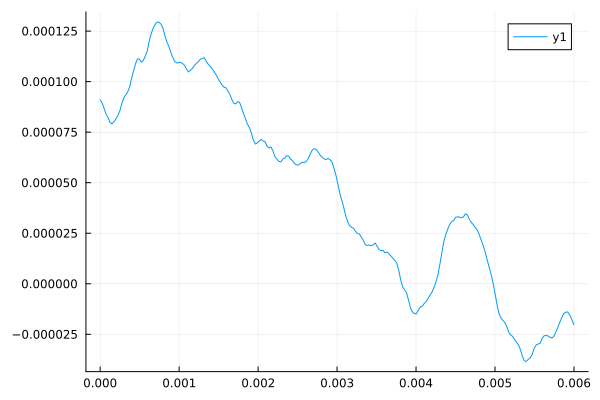

In [34]:
plot(sol.t .* (1/Γ), z.(sol.u))

# Figure 1

In [35]:
using ProgressMeter

In [237]:
@everywhere begin
    prob.p.params.x_dist = Normal(0,700e-6)
    prob.p.params.y_dist = Normal(0,700e-6)
    prob.p.params.z_dist = Normal(0,400e-6)

    T_initial = 35e-6
    prob.p.params.vx_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vy_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vz_dist = Normal(0, sqrt(kB*T_initial/2m))
end
;

In [238]:
s_scan_values = (0.3:0.2:2.1) .* (s ./ 0.7)

10-element Vector{Float64}:
  1.467440415302919
  2.445734025504865
  3.424027635706811
  4.402321245908757
  5.380614856110704
  6.358908466312649
  7.337202076514595
  8.315495686716542
  9.293789296918487
 10.272082907120435

In [241]:
@everywhere function update_sats!(prob, sats)
    ϵs = prob.p.ϵs
    for k ∈ 1:3
        for q ∈ axes(prob.p.ϵs,3)
            for f ∈ eachindex(sats)
                prob.p.ϵs_scaled[k,f,q] = prob.p.ϵs[k,f,q] * (sqrt(sats[f]) / (2*√2))
                prob.p.ϵs_scaled[k+3,f,q] = prob.p.ϵs[k+3,f,q] * (sqrt(sats[f]) / (2*√2))
            end
        end
    end
    return nothing
end
; 

In [242]:
@everywhere n_avgs = 10

n_steps = n_avgs * length(workers()) * length(s_scan_values)
p = Progress(n_steps)
channel = RemoteChannel(() -> Channel{Bool}(), 1)

all_sols = []

@sync begin
    @async while take!(channel)
        next!(p)
    end
    
    @async begin
        for i ∈ eachindex(s_scan_values)
            s = s_scan_values[i]
            
            @everywhere begin
                prob.p.sats[1] = $(0.37s)
                prob.p.sats[2] = $(0.28s)
                prob.p.sats[3] = $(0.35s)
                update_sats!(prob, prob.p.sats)
            end

            sols_futures = Vector{Future}()
            for pid ∈ workers()
                sols_future = @spawnat pid begin
                    sols_workers = []
                    for j ∈ 1:n_avgs
                        put!(channel, true)
                        prob_func!(prob)
                        sol = DifferentialEquations.solve(prob)
                        push!(sols_workers, sol)
                    end
                    sols_workers
                end
                push!(sols_futures, sols_future)
            end
            sols = vcat(fetch.(sols_futures)...)
            push!(all_sols, sols)
        end
        put!(channel, false)
    end
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:08:44


In [245]:
σs

10-element Vector{Float64}:
 3.629170256632185e-5
 3.824844218589389e-5
 3.733253391285661e-5
 3.66009560318014e-5
 3.990953949029944e-5
 4.46845709234897e-5
 4.085778557669639e-5
 4.8938574985042466e-5
 4.932457465570279e-5
 5.631622356251248e-5

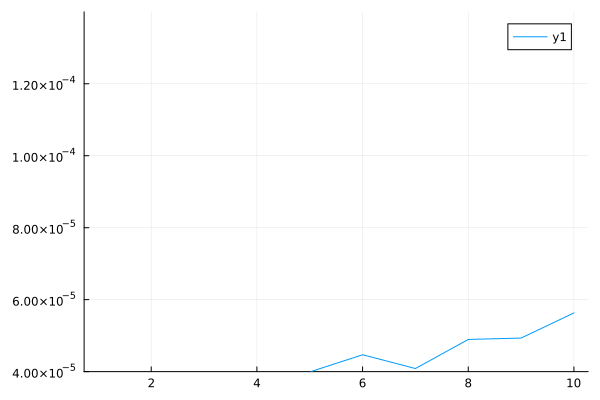

In [248]:
σs = σ_geom_ensemble_sol.(all_sols)
plot(σs, ylim=(40e-6,140e-6))

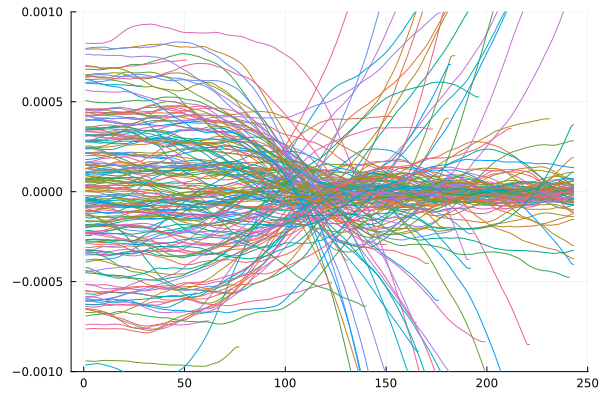

In [249]:
xs = [z.(sol.u) for sol ∈ all_sols[1]]
plot(
    xs,
    legend=nothing,
    ylim=(-1e-3,1e-3)
    )

In [547]:
@everywhere begin
    n_avgs  = 200000
    n_times = 100
    t_end   = 1e-6
    τ_total = 1e-6
    
    p = initialize_prob(sim_type, energies, freqs, sats, pols, ψ0, d, m/(ħ*k^2/Γ), Γ, params, add_terms_dψ)
    p.diffusion_constant = zeros(3)
    
    cb1 = ContinuousCallback(condition_new, stochastic_collapse_new!, save_positions=(false,false))
    
    kwargs = (alg=DP5(), reltol=1e-3, saveat=1000, callback=cb1)
    
    prob = ODEProblem(ψ_fast!, u0, sim_type.(t_span), p; kwargs...)
end

In [548]:
@everywhere begin
    prob.p.params.x_dist = Normal(0,70e-6)
    prob.p.params.y_dist = Normal(0,70e-6)
    prob.p.params.z_dist = Normal(0,40e-6)

    T_initial = 150e-6
    prob.p.params.vx_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vy_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vz_dist = Normal(0, sqrt(kB*T_initial/2m))

    prob.p.params.B_ramp_time = 1e-10 / (1/Γ)
    prob.p.params.s_ramp_time = 1e-10 / (1/Γ)
end
;

In [549]:
using Bootstrap

diffusions = zeros(length(s_scan_values))
diffusion_errors = zeros(length(s_scan_values))
diffusions_over_time = Vector{Float64}[]

n_steps = n_avgs * length(workers()) * length(s_scan_values)
p = Progress(n_steps)
channel = RemoteChannel(() -> Channel{Bool}(), 1)

@sync begin
    @async while take!(channel)
        next!(p)
    end
    
    @async begin
        for i ∈ eachindex(s_scan_values)
            s = s_scan_values[i]
            
            @everywhere begin
                prob.p.sats[1] = $(0.37s)
                prob.p.sats[2] = $(0.28s)
                prob.p.sats[3] = $(0.35s)
                update_sats!(prob, prob.p.sats)
                
                prob.p.diffusion_constant = $(0 .* [diffusions[i], diffusions[i], diffusions[i]])
            end

            futures = Vector{Future}()
            for pid ∈ workers()
                future = @spawnat pid compute_diffusion(prob, prob_func!, n_avgs, t_end, τ_total, n_times, channel)
                push!(futures, future)
            end
            rets = fetch.(futures)

            Cs = real.(ret[1] for ret ∈ rets)
            fτ_fts = real.(ret[2] for ret ∈ rets)
            Cs_integrated = vcat(real.(ret[3] for ret ∈ rets)...)
            fτ_fts_integrated = vcat(real.(ret[4] for ret ∈ rets)...)

            diffusion_over_time = mean(Cs) .- mean(fτ_fts)
            push!(diffusions_over_time, diffusion_over_time)

            diffusion = Cs_integrated .- fτ_fts_integrated
            diffusions[i] = mean(diffusion)

            bs = bootstrap(mean, diffusion, BasicSampling(1000))
            diffusion_errors[i] = stderror(bs)[1]
        end
        put!(channel, false)
    end
end
;

Progress: 100%|█████████████████████████████████████████| Time: 2:55:3939m


In [550]:
diffusions

10-element Vector{Float64}:
 0.01103187807964739
 0.01682470301834082
 0.020955241355565198
 0.024167271360811093
 0.026643269424192977
 0.02904099836756618
 0.03132384649165801
 0.03328677359723972
 0.0355790406287299
 0.037603602198440604

In [551]:
diffusion_errors

10-element Vector{Float64}:
 4.486774813684235e-5
 6.405634345491202e-5
 7.248663683792289e-5
 7.994246038752209e-5
 9.026516076740051e-5
 0.00010239418938640849
 0.00010702347762714264
 0.00011448912177271699
 0.00011790615506903917
 0.00012879294757481424

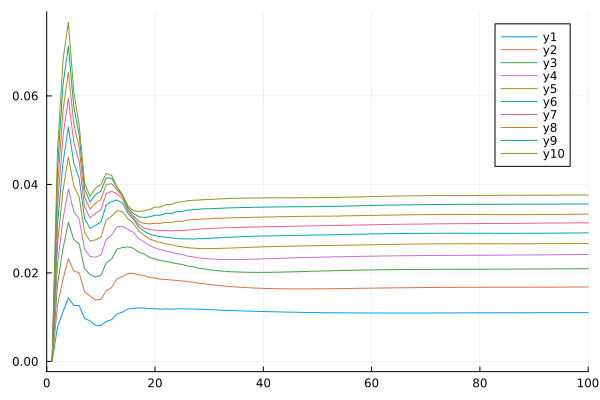

In [552]:
plot(diffusions_over_time, xlim=(0,100))

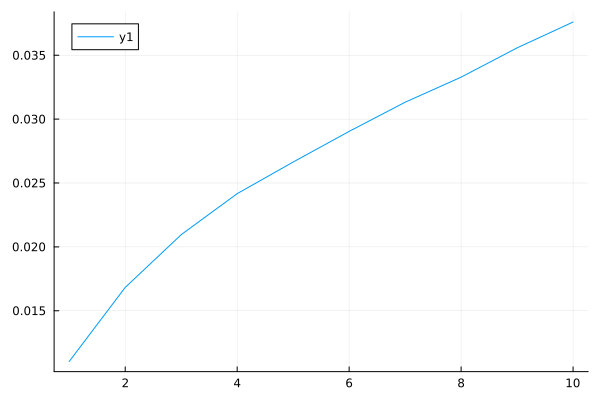

In [553]:
plot(diffusions)

In [605]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    p = initialize_prob(sim_type, energies, freqs, sats, pols, ψ0, d, m/(ħ*k^2/Γ), Γ, params, add_terms_dψ)
    
    u0 = sim_type.([zeros(p.n_states)..., zeros(p.n_states)..., zeros(4)..., zeros(3)..., zeros(3)..., zeros(3)..., zeros(3)...])
    u0[1] = 1.0
    
    cb1 = ContinuousCallback(condition_new, stochastic_collapse_new!, save_positions=(false,false))
    cb2 = DiscreteCallback(terminate_condition, terminate!)
    cbs = CallbackSet(cb1,cb2)
    
    kwargs = (alg=DP5(), reltol=1e-3, saveat=1000, maxiters=200000000, callback=cbs)
    
    prob = ODEProblem(ψ_fast!, u0, sim_type.(t_span), p; kwargs...)
end
;

In [606]:
@everywhere begin
    prob.p.params.x_dist = Normal(0,700e-6)
    prob.p.params.y_dist = Normal(0,700e-6)
    prob.p.params.z_dist = Normal(0,400e-6)

    T_initial = 35e-6
    prob.p.params.vx_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vy_dist = Normal(0, sqrt(kB*T_initial/2m))
    prob.p.params.vz_dist = Normal(0, sqrt(kB*T_initial/2m))

    prob.p.params.B_ramp_time = 4e-3 / (1/Γ)
    prob.p.params.s_ramp_time = 4e-3 / (1/Γ)
end
;

In [607]:
@everywhere n_avgs = 100

n_steps = n_avgs * length(workers()) * length(s_scan_values)
p = Progress(n_steps)
channel = RemoteChannel(() -> Channel{Bool}(), 1)

all_sols = []

@sync begin
    @async while take!(channel)
        next!(p)
    end
    
    @async begin
        for i ∈ eachindex(s_scan_values)
            s = s_scan_values[i]
            
            @everywhere begin
                prob.p.sats[1] = $(0.37s)
                prob.p.sats[2] = $(0.28s)
                prob.p.sats[3] = $(0.35s)
                update_sats!(prob, prob.p.sats)
                
                prob.p.diffusion_constant = $([diffusions[i], diffusions[i], diffusions[i]])
            end

            sols_futures = Vector{Future}()
            for pid ∈ workers()
                sols_future = @spawnat pid begin
                    sols_workers = []
                    for j ∈ 1:n_avgs
                        put!(channel, true)
                        prob_func!(prob)
                        sol = DifferentialEquations.solve(prob)
                        push!(sols_workers, sol)
                    end
                    sols_workers
                end
                push!(sols_futures, sols_future)
            end
            sols = vcat(fetch.(sols_futures)...)
            push!(all_sols, sols)
        end
        put!(channel, false)
    end
end
;

Progress: 100%|█████████████████████████████████████████| Time: 1:09:55


3-element Vector{Float64}:
    4.430316621048644e-5
   -1.4107515125160534e-7
 8898.302135359598

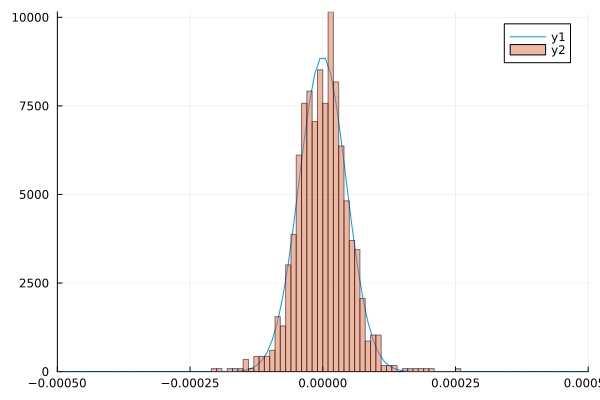

In [615]:
zs = [z(sol.u[end]) for sol ∈ all_sols[3] if survived(sol)]

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2σ^2))
end

hist_data = fit(Histogram, zs, -1e-3:1e-5:1e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-0.5e-3, +0.5e-3), alpha=0.5, normalize=true)

In [616]:
hist_data = fit(Histogram, zs, -0.3e-3:3e-6:0.3e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(gaussian, v, fv, [60e-6, 0., 10000])
σ, x0, A = v_fit.param

3-element Vector{Float64}:
    4.4333886124764166e-5
   -9.356349332773493e-8
 8905.658145557543

In [617]:
σs = σ_geom_ensemble_sol.(all_sols)

10-element Vector{Float64}:
 7.59813042443504e-5
 5.7989994648389554e-5
 5.544628036720598e-5
 5.757247318820989e-5
 5.860580639096705e-5
 6.480553695492968e-5
 6.981292930028465e-5
 7.472468702649507e-5
 7.805843243058738e-5
 8.529622065089338e-5

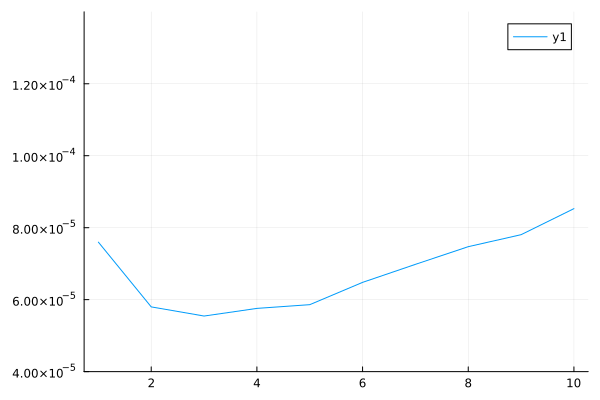

In [618]:
σs = σ_geom_ensemble_sol.(all_sols)
plot(σs, ylim=(40e-6,140e-6))

In [620]:
Ts = T_ensemble_sol.(all_sols) 

10-element Vector{Float64}:
 0.00017524838790110279
 0.00014862514258583807
 0.0001500873131947441
 0.0001610239977223923
 0.00018181507029851562
 0.0001992499144869347
 0.0002215560774000036
 0.0002451659145825233
 0.00025736304316736875
 0.0002903556988289974

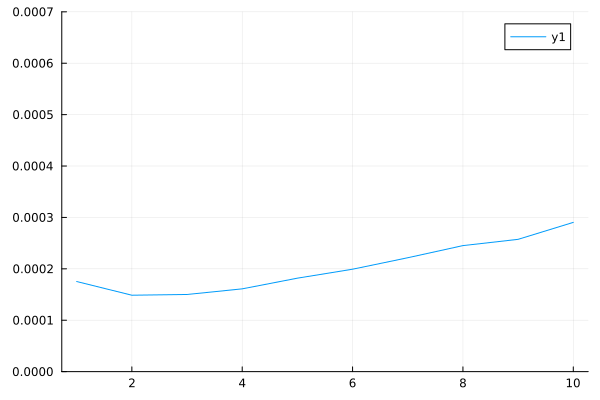

In [621]:
plot(Ts, ylim=(0,700e-6))

In [593]:
Ts = T_ensemble_sol.(ensemble_sols)
Ts |> plot

LoadError: UndefVarError: `ensemble_sols` not defined

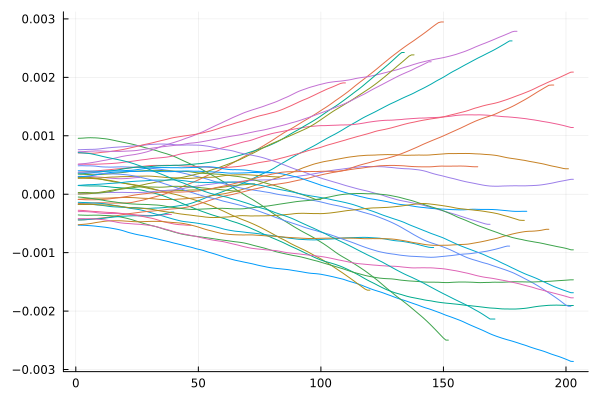

In [575]:
xs = [z.(sol.u) for sol ∈ all_sols[1]]
plot(
    xs,
    legend=nothing,
    # ylim=(-0.5e-3,0.5e-3)
    )

In [65]:
photons_scattered = [sol.prob.p.n_scatters for sol ∈ ensemble_sols[1]]
lifetimes = [sol.t[end] * (1/Γ) for sol ∈ ensemble_sols[1]]
;

In [66]:
scattering_rate = sum(photons_scattered) / sum(lifetimes)

887425.9215459882